In [1]:
"""
   Copyright (C) 2024 ETH Zurich. All rights reserved.
   Author: Sergei Vostrikov, ETH Zurich
           Cedric Hirschi, ETH Zurich
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at
       http://www.apache.org/licenses/LICENSE-2.0
   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

   SPDX-License-Identifier: Apache-2.0
"""

'\n   Copyright (C) 2024 ETH Zurich. All rights reserved.\n   Author: Sergei Vostrikov, ETH Zurich\n           Cedric Hirschi, ETH Zurich\n   Licensed under the Apache License, Version 2.0 (the "License");\n   you may not use this file except in compliance with the License.\n   You may obtain a copy of the License at\n       http://www.apache.org/licenses/LICENSE-2.0\n   Unless required by applicable law or agreed to in writing, software\n   distributed under the License is distributed on an "AS IS" BASIS,\n   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n   See the License for the specific language governing permissions and\n   limitations under the License.\n\n   SPDX-License-Identifier: Apache-2.0\n'

# If you are not familiar with Jupyter Notebooks, please first check online tutorials such as https://realpython.com/jupyter-notebook-introduction/#creating-a-notebook

In [2]:
#%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import wulpus.rx_tx_conf_gui as conf_gui

# Generate Transmit/Receive configs using the GUI
conf_gen = conf_gui.WulpusRxTxConfigGenGUI()

display(conf_gen)

WulpusRxTxConfigGenGUI(children=(HBox(children=(Dropdown(description='Config:', options=(0, 1, 2, 3, 4, 5, 6, …

In [5]:
from wulpus.uss_conf import WulpusUssConfig, PGA_GAIN
from wulpus.uss_conf_gui import WulpusUssConfigGUI

# Get TX/RX configurations
tx_confs = conf_gen.get_tx_configs()
rx_confs = conf_gen.get_rx_configs()

print('TX config: ', np.binary_repr(tx_confs[0]))
print('RX config: ', np.binary_repr(rx_confs[0]))

# Create US subsystem configuration
uss_conf = WulpusUssConfig(num_acqs=800,
                           dcdc_turnon=100,
                           start_hvmuxrx=500,
                           meas_period=20000,
                           num_txrx_configs=len(tx_confs),
                           tx_configs=tx_confs,
                           rx_configs=rx_confs,
                           rx_gain=PGA_GAIN[12],
                           trans_freq=2250000,
                           num_pulses=2,
                           sampling_freq=8000000)

# Modify US subsystem configuration using the GUI
uss_conf = WulpusUssConfigGUI(uss_conf)

# Or Load settings from a file
# uss_conf.with_file('uss_config.json')

print("Gain dB: ", uss_conf.rx_gain)

display(uss_conf)

TX config:  10000000
RX config:  1000000
Gain dB:  3.5


WulpusUssConfigGUI(children=(HBox(children=(VBox(children=(HTML(value='<b>Measurement settings</b>'), BoundedI…

### Initialize a connection

We initialize a `WulpusDongle` object here such that it can run independently from the GUI.

In [6]:
from wulpus.dongle import WulpusDongle

# Create a dongle object
dongle = WulpusDongle()

### Run GUI 
(Check the WULPUS user manual (chapter 3 and 4) for more information)

Init
Scan


WulpusGuiSingleCh(children=(VBox(children=(HBox(children=(VBox(children=(Checkbox(value=True, description='Sho…

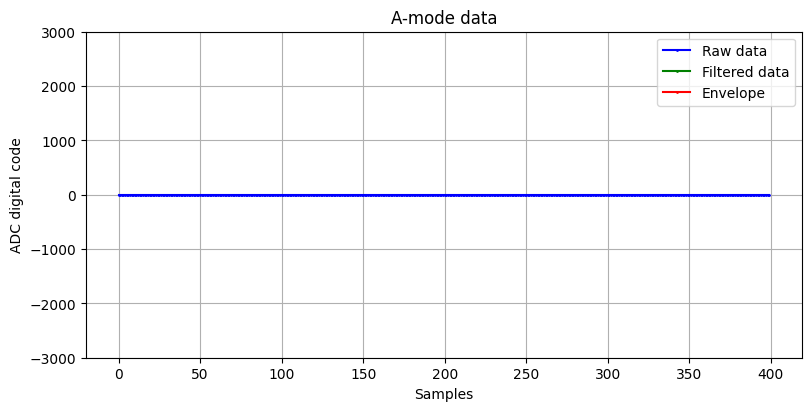

In [108]:
#%matplotlib widget
from wulpus.gui import WulpusGuiSingleCh

# Create a GUI
try:
    # Check if the GUI object already exists
    gui
except NameError:
    # Does not exist. Create a new GUI
    gui = WulpusGuiSingleCh(dongle, uss_conf, max_vis_fps = 20)
else:
    # Exist. First, close the COM port and then create a new GUI
    if gui.port_opened:
        gui.com_link.__ser__.close()
    gui = WulpusGuiSingleCh(dongle, uss_conf, max_vis_fps = 20)

display(gui)

## Loading and interpreting the saved data

The data is saved in a `.npz` file. This is a compressed file format that can be used with the `numpy` library.

Explore an example below to learn how to load and interpret the data.

In [197]:
# Data can be loaded as easy as:
data = np.load('./data_19.npz')

# The keys of the data are:
print('Keys:', data.files)

Keys: ['data_arr', 'acq_num_arr', 'tx_rx_id_arr']


In [198]:
# Transpose the data such that we can index via time
data_meas = data['data_arr'].T
channel_id = 128

data_sel = data_meas[data['tx_rx_id_arr'] == channel_id, :]
data_sel.shape

(6, 400)

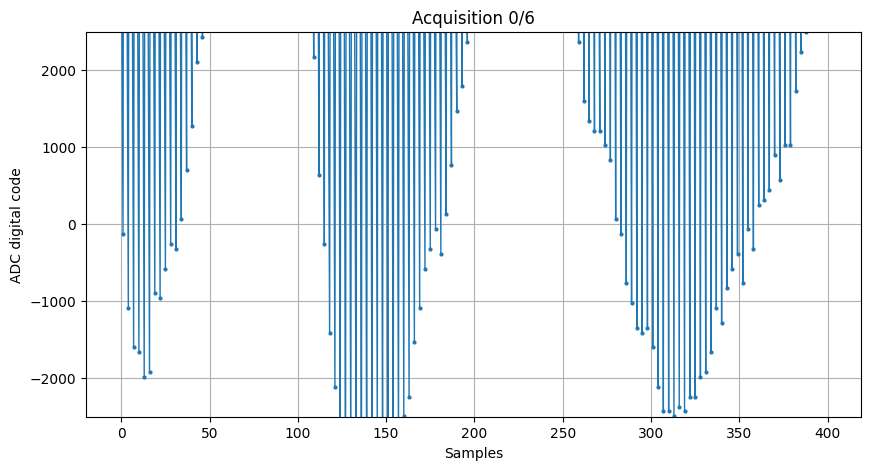

interactive(children=(IntSlider(value=5, description='frame', max=5), Output()), _dom_classes=('widget-interac…

<function __main__.visualize(frame)>

In [199]:
plt.figure(figsize=(10, 5))
plot_data = plt.plot(data_sel[0], linestyle='-', marker='o', linewidth=1, markersize=2)
plt.ylim(-2500, 2500)
plt.title(f'Acquisition 0/{data_sel.shape[0]}')
plt.xlabel('Samples')
plt.ylabel('ADC digital code')
plt.grid()
plt.show()

def visualize(frame):
    plot_data[0].set_ydata(data_sel[frame])
    plt.title(f'Acquisition {frame}/{data_sel.shape[0]}')
    plt.draw()

widgets.interact(visualize, frame=widgets.IntSlider(min=0, max=data_sel.shape[0]-1, step=1, value=10))

A user can further perform band-pass filtering and application-specific processing of the raw data.

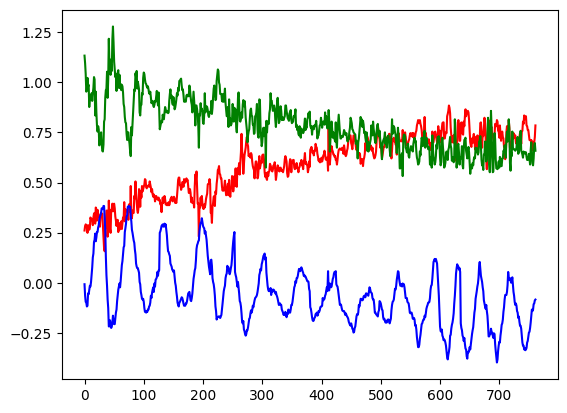

In [200]:
Xs = []
Ys = []
Zs = []

for frame in data_sel:
    for i in range(0,len(frame)-20,3):
        X = ((frame[i]) >>6)*0.06125/16
        Y = ((frame[i+1])>>6)*0.06125/16
        Z = ((frame[i+2] )>>6)*0.06125/16
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)


plt.plot(Xs, "r")
plt.plot(Ys, "b")
plt.plot(Zs, "g")
plt.show()
